### https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

## Set up Dataset

In [10]:
import pandas as pd
import numpy as np

HealthData = pd.read_csv('/Users/janruffner/Desktop/HealthcareFraudCapstoneProject/Data/HealthData.csv', index_col=0)

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
X=HealthData.drop(['PotentialFraud2','Majority', 'Majority_1'], axis=1)
y=HealthData[['PotentialFraud2']]

## Create testing and training sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2, random_state=42)

## Import model library

In [18]:
from xgboost import XGBClassifier
from matplotlib import pyplot

## Grid Search for Optimal Parameters using Cross-Validation

In [ ]:
# Number of trees in random forest
n_estimators = [40,100] #[int(x) for x in np.linspace(start=10, stop=80, num=10)]
# Maximum number of levels in tree
max_depth = [i*2+3 for i in range(1,5)] + [None]
# Minimum number of samples required to split a node
learning_rates = [10**i for i in range(-3,2)]
# Method of selecting learning rate
colsample_bytree = [0.5, 0.8, 1]
# number of columns used by each tree
gamma = [0,1,5]
# Acts as a regularization parameter

bootstrap = [True]

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
             'learning_rates': learning_rates,
             'colsample_bytree': colsample_bytree,
             'gamma': gamma}

In [ ]:
%timeit
xgb = XGBClassifier(n_estimators =100,
                    max_depth=5,
                    learning_rates=0.001,
                    colsample_bytree=0.5,
                    gamma=0,
                    random_state=42, 
                   objective='binary:logistic')
from sklearn.model_selection import GridSearchCV
xgb_Grid = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=10, verbose=2, n_jobs=4)
xgb_Grid.fit(X_train,y_train)

## Select the best version of the model

In [14]:
print(xgb_Grid.best_params_)
xgb_best = xgb_Grid.best_estimator_

{'colsample_bytree': 0.8, 'gamma': 5, 'learning_rates': 0.001, 'max_depth': 7, 'n_estimators': 40}


In [16]:
xgb_best.score(X_test, y_test)

0.9399260628465804

In [19]:
xgb = XGBClassifier(n_estimators =40,
                    max_depth=7,
                    learning_rates=0.001,
                    colsample_bytree=0.8,
                    gamma=5,
                    random_state=42) 

xgb.fit(X_train, y_train) 

[15:17:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { learning_rates } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:17:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, learning_rates=0.001, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=40, n_jobs=16,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [20]:
xgb_best.score(X_train, y_train)

0.95771719038817

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, xgb_best.predict(X_train))

array([[3897,   26],
       [ 157,  248]])

In [22]:
confusion_matrix(y_test, xgb_best.predict(X_test))

array([[959,  22],
       [ 43,  58]])

In [23]:
xgb_best.score(X_test, y_test)

0.9399260628465804

## Feature Importance

In [24]:
feature_importances = xgb_best.feature_importances_ 
feature_list = list(X_train)
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])
relative_importances.sort_values(by="importance", ascending=False)

,importance
sum.InscClaimAmtReimbursed,0.148754
OupatientInpatient2Ratio,0.133613
sum.BeneID,0.098028
sum.ChronicCond_Heartfailure,0.064017
sum.ChronicCond_rheumatoidarthritis,0.054199
...,...
Majority_23,0.000000
Majority_24,0.000000
Majority_25,0.000000
Majority_26,0.000000


<AxesSubplot:>

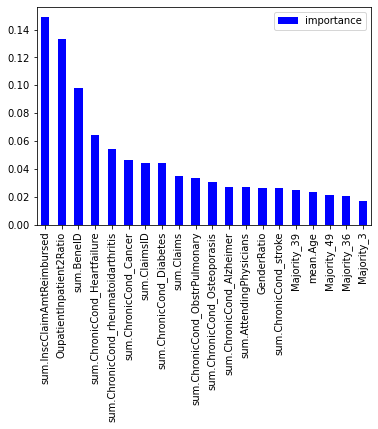

In [26]:
relative_importances.sort_values(by="importance", ascending=False).head(20).plot.bar(color='b')